In [11]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
%matplotlib inline

In [12]:
df_path = "data/cleaned_diabetic_data.csv"

try:
    df = pd.read_csv(df_path)
    print("Dataset loaded from:", df_path)
except Exception as e:
    raise RuntimeError(f"Could not load {df_path}. Error: {e}")

Dataset loaded from: data/cleaned_diabetic_data.csv


In [13]:
# Define feature matrix X and target y
target_col = 'readmit_30d'
y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

# For modeling: separate numeric and categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features[:10])
print("Categorical features (sample):", categorical_features[:20])

# Build preprocessing pipeline:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # drop any columns not specified
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Numeric features: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']
Categorical features (sample): ['race', 'gender', 'age', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose']
Train shape: (81412, 46) Test shape: (20354, 46)


In [14]:
# === Model 1: Logistic Regression ===
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

print("Training Logistic Regression...")
lr_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:,1]

# Evaluate
def evaluate_model(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc}

metrics_lr = evaluate_model(y_test, y_pred_lr, y_prob_lr)
print("Logistic Regression metrics:")
print(metrics_lr)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, zero_division=0))


Training Logistic Regression...
Logistic Regression metrics:
{'accuracy': 0.6476368281418886, 'precision': 0.17191056366314098, 'recall': 0.5653896961690885, 'f1': 0.26365503080082137, 'roc_auc': 0.657311034570203}

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.66      0.77     18083
           1       0.17      0.57      0.26      2271

    accuracy                           0.65     20354
   macro avg       0.55      0.61      0.52     20354
weighted avg       0.84      0.65      0.71     20354



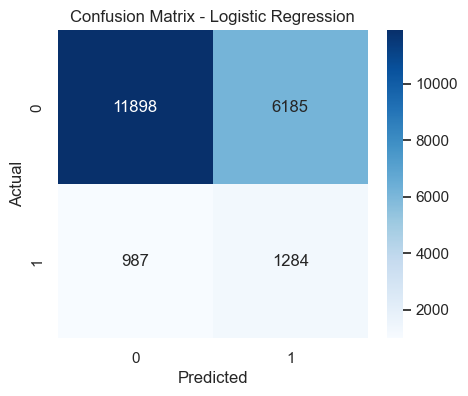

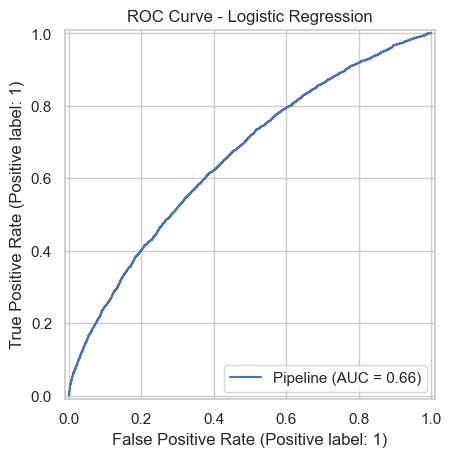

In [15]:
# Confusion matrix for Logistic Regression
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(lr_pipeline, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()


In [16]:
# === Model 2: Random Forest ===
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'))
])

print("Training Random Forest")
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:,1]

metrics_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf)
print("Random Forest metrics:")
print(metrics_rf)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))


Training Random Forest
Random Forest metrics:
{'accuracy': 0.8887196619829026, 'precision': 0.7142857142857143, 'recall': 0.004403346543372964, 'f1': 0.0087527352297593, 'roc_auc': 0.6582257827567599}

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.71      0.00      0.01      2271

    accuracy                           0.89     20354
   macro avg       0.80      0.50      0.47     20354
weighted avg       0.87      0.89      0.84     20354



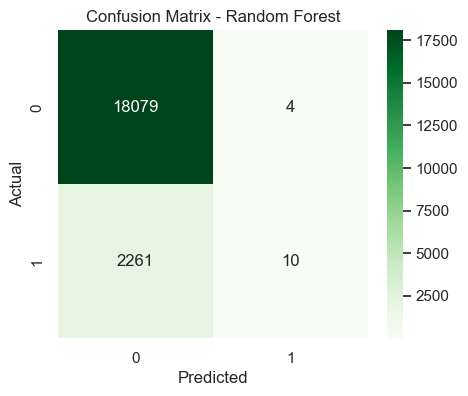

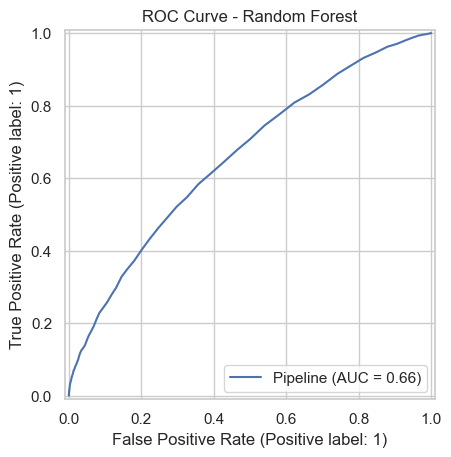

In [17]:
# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(rf_pipeline, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()


In [18]:
# === Model Comparison Table ===
comparison = pd.DataFrame([metrics_lr, metrics_rf], index=['LogisticRegression', 'RandomForest'])
display(comparison)

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.647637,0.171911,0.565390,0.263655,0.657311
RandomForest,0.888720,0.714286,0.004403,0.008753,0.658226
